In [1]:
import calendar
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ETSModel, SimpleExpSmoothing, seasonal_decompose, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import altair_ally as aly
import plotly.graph_objects as go
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


%matplotlib inline

#### Read in data from excel workbook

In [2]:
excel_df = pd.read_excel('LP_data.xlsx', sheet_name='Sheet2')
excel_df[excel_df.select_dtypes(include='number').columns] = excel_df.select_dtypes(include='number').round(2)

#### Read in weather data downloaded from https://vancouver.weatherstats.ca/

In [3]:
van_weather_df = pd.read_csv('weatherstats_vancouver_daily.csv')
van_weather_df['date'] = pd.to_datetime(van_weather_df['date'])

#### Filter dates that have corresponding sales data

In [4]:
start_date = excel_df['date'].min()
end_date = excel_df['date'].max()
van_weather_df = van_weather_df[(van_weather_df['date'] >= start_date) & 
               (van_weather_df['date'] <= end_date)
               ]
van_weather_df = van_weather_df.iloc[::-1] #flip the order with the most recent date at the bottom


In [5]:
## filtering for weather columns that we will use for the modelling
weather_columns_for_model = ['date','avg_temperature', 'rain', 'snow', 'avg_cloud_cover_8']

In [6]:
## joining the weather data to our dataset
combined_df = pd.merge(excel_df, van_weather_df[weather_columns_for_model], on='date', how='left')


In [7]:
def is_long_weekend(type_of_days):

    is_long_weekend_list = [False] * len(type_of_days)

    for i ,day in enumerate(type_of_days):

        if day == 'Holiday':
            prev_day = type_of_days[i-1] if i > 0 else None
            next_day = type_of_days[i+1] if i < len(type_of_days) - 1 else None 
            
            if prev_day == 'Weekend':
                is_long_weekend_list[i] = True
                is_long_weekend_list[i-1] = True
                is_long_weekend_list[i-2] = True
            
            if next_day == 'Weekend':
                is_long_weekend_list[i] = True
                is_long_weekend_list[i+1] = True
                is_long_weekend_list[i+2] = True
    
    return pd.Series(is_long_weekend_list, name='is_long_weekend')

In [8]:
def is_HCF(dates, start, end):

    start = pd.Timestamp(start)
    end = pd.Timestamp(end)

    HCF_days = dates.apply(lambda day: start <= day <= end)
    HCF_days.name = 'is_HCF'

    return HCF_days

In [9]:
def is_holiday(dates):

    holidays = dates.apply(lambda day: day == 'Holiday')

    return holidays

In [10]:
def has_pop_up(dates, pop_up_days):

    pop_up_days_dt = pd.to_datetime(pop_up_days)

    have_pop_up = dates.apply(lambda day: day in pop_up_days_dt)
    have_pop_up.name = 'has_pop_up'

    return have_pop_up

In [11]:
pop_up_days = [
    '2024-11-16',
    '2024-11-17',
    '2024-11-23',
    '2024-12-28',
    '2024-12-29',
    '2025-01-25',
    '2025-01-26',
    '2025-03-01',
    '2025-03-02',
    '2025-03-08',
    '2025-03-09',
    '2025-03-15',
    '2025-03-16',
    '2025-03-22',
    '2025-03-23',
    '2025-03-29',
    '2025-03-30',
    '2025-03-30',
    '2025-04-05',
    '2025-04-06',
    '2025-04-12',
    '2025-04-13',
    '2025-04-18',
    '2025-04-19',
    '2025-04-20',
    '2025-04-21',
    '2025-04-26',
    '2025-04-27',
    '2025-05-03',
    '2025-05-04',
]

In [12]:
def get_season(dates: pd.Series) -> pd.Series:
    """
    Given a Series of datetime objects, return a Series with the season for each date.
    Seasons are based on meteorological seasons in the Northern Hemisphere.
    """
    def season_of_date(date):
        month = date.month
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    return dates.apply(season_of_date).rename("season")

In [136]:
excel_df.columns

Index(['date', 'hours_opened', 'net_sales_normalized', 'tips_normalized',
       'total_sales_normalized', 'in_store_sales', 'pick-up', 'ubereats',
       'in_store_orders', 'pick_up_orders', 'uber_orders', 'item_A_sales',
       'item_B_sales', 'item_C_sales', 'item_D_sales', 'item_E_sales',
       'other_sales', 'gift_card_sales', 'HCF_sales', 'net_sales_per_order',
       'type_of_day', 'note'],
      dtype='object')

In [137]:
excel_columns_for_model = excel_df[['date', 'hours_opened', 'total_sales_normalized', 'type_of_day', 'note']]

In [14]:
combined_df['is_long_weekend'] = is_long_weekend(combined_df['type_of_day'])
combined_df['is_HCF'] = is_HCF(combined_df['date'], '2025-01-18', '2025-02-14')
combined_df['has_pop_up'] = has_pop_up(combined_df['date'], pop_up_days)
combined_df['season'] = get_season(combined_df['date'])
combined_df['is_holiday'] = is_holiday(combined_df['type_of_day'])
combined_df['day_of_week'] = combined_df['date'].dt.day_name()

In [15]:
## set sales of unusual days as average of usual days 

combined_df.loc[combined_df['type_of_day'] == 'Unusual', 'total_sales_normalized'] = combined_df.loc[(combined_df['type_of_day'] != 'Unusual') & (combined_df['day_of_week'] == 'Monday'), 'total_sales_normalized'].mean()

In [21]:
train_df = combined_df[['total_sales_normalized', 'item_A_sales', 'item_B_sales', 'item_C_sales' ,'hours_opened', 'is_long_weekend', 'is_HCF', 'type_of_day', 'has_pop_up', 'rain', 'snow', 'avg_cloud_cover_8', 'avg_temperature', 'season', 'day_of_week', 'is_holiday']].copy()

In [22]:
train_df['is_long_weekend'] = pd.Categorical(train_df['is_long_weekend'], categories=[False, True])
train_df['is_holiday'] = pd.Categorical(train_df['is_holiday'], categories=[False, True])
train_df['is_HCF'] = pd.Categorical(train_df['is_HCF'], categories=[False, True])
train_df['type_of_day'] = pd.Categorical(train_df['type_of_day'], categories=['Weekday', 'Friday', 'Weekend', 'Holiday'])
train_df['day_of_week'] = pd.Categorical(train_df['day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
train_df['has_pop_up'] = pd.Categorical(train_df['has_pop_up'], categories=[False, True])
train_df['season'] = pd.Categorical(train_df['season'], categories=['Winter', 'Spring', 'Summer', 'Fall'])
train_df['log_total_sales_normalized'] = np.log(train_df['total_sales_normalized'])
train_df['log_item_A_sales'] = np.log(train_df['item_A_sales'].replace(0, 1e-6))
train_df['log_item_B_sales'] = np.log(train_df['item_B_sales'].replace(0, 1e-6))
train_df['log_item_C_sales'] = np.log(train_df['item_C_sales'].replace(0, 1e-6))


#### Exploratory data analysis

In [187]:
aly.dist(train_df)

alt.ConcatChart(...)

In [21]:
round(train_df.describe(),2)

,total_sales_normalized,item_A_sales,item_B_sales,item_C_sales,hours_opened,rain,snow,avg_cloud_cover_8,avg_temperature,log_total_sales_normalized,log_item_A_sales,log_item_B_sales,log_item_C_sales
count,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00,340.00
mean,2975.94,1186.99,1253.53,257.79,11.31,3.33,0.06,4.65,10.48,7.90,7.00,6.96,5.43
std,1265.49,476.34,691.38,126.68,0.78,6.99,0.55,1.92,5.96,0.44,0.40,0.68,0.50
min,665.11,375.55,0.00,41.00,5.00,0.00,0.00,0.00,-4.95,6.50,5.93,0.00,3.71
25%,1882.80,801.04,663.38,163.25,11.00,0.00,0.00,4.00,6.48,7.54,6.69,6.50,5.10
50%,2873.34,1105.06,1131.45,241.00,11.00,0.00,0.00,4.50,10.05,7.96,7.01,7.03,5.48
75%,3777.98,1496.97,1643.45,325.00,12.00,4.00,0.00,6.00,15.55,8.24,7.31,7.40,5.78
max,7444.84,3810.20,3633.71,785.00,12.00,67.10,5.80,8.00,21.95,8.92,8.25,8.20,6.67


In [44]:
aly.corr(train_df.drop(columns=['log_item_A_sales', 'item_A_sales', 'log_item_B_sales', 'item_B_sales', 'item_C_sales', 'log_item_C_sales']))

alt.ConcatChart(...)

In [47]:
aly.corr(train_df.drop(columns=['log_total_sales_normalized', 'total_sales_normalized', 'log_item_B_sales', 'item_B_sales', 'item_C_sales', 'log_item_C_sales']))

alt.ConcatChart(...)

In [48]:
aly.corr(train_df.drop(columns=['log_total_sales_normalized', 'total_sales_normalized', 'log_item_A_sales', 'item_A_sales', 'item_C_sales', 'log_item_C_sales']))

alt.ConcatChart(...)

In [49]:
aly.corr(train_df.drop(columns=['log_total_sales_normalized', 'total_sales_normalized', 'log_item_A_sales', 'item_A_sales', 'log_item_B_sales', 'item_B_sales',]))

alt.ConcatChart(...)

In [50]:
train_df.columns

Index(['total_sales_normalized', 'item_A_sales', 'item_B_sales',
       'item_C_sales', 'hours_opened', 'is_long_weekend', 'is_HCF',
       'type_of_day', 'has_pop_up', 'rain', 'snow', 'avg_cloud_cover_8',
       'avg_temperature', 'season', 'log_total_sales_normalized',
       'log_item_A_sales', 'log_item_B_sales', 'log_item_C_sales'],
      dtype='object')

## Regression models

#### Untransformed sales - > heteroscadasticity 

In [51]:
formula = (
    """
        total_sales_normalized ~ hours_opened 
        + C(is_HCF) 
        + C(type_of_day) 
        + C(has_pop_up) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + C(season)
        + C(type_of_day): rain 
    """
    )

interaction_model = smf.ols(formula, data=train_df).fit()

In [52]:
print(interaction_model.summary())

                              OLS Regression Results                              
Dep. Variable:     total_sales_normalized   R-squared:                       0.862
Model:                                OLS   Adj. R-squared:                  0.855
Method:                     Least Squares   F-statistic:                     126.2
Date:                    Wed, 21 May 2025   Prob (F-statistic):          2.61e-128
Time:                            22:42:54   Log-Likelihood:                -2573.8
No. Observations:                     340   AIC:                             5182.
Df Residuals:                         323   BIC:                             5247.
Df Model:                              16                                         
Covariance Type:                nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

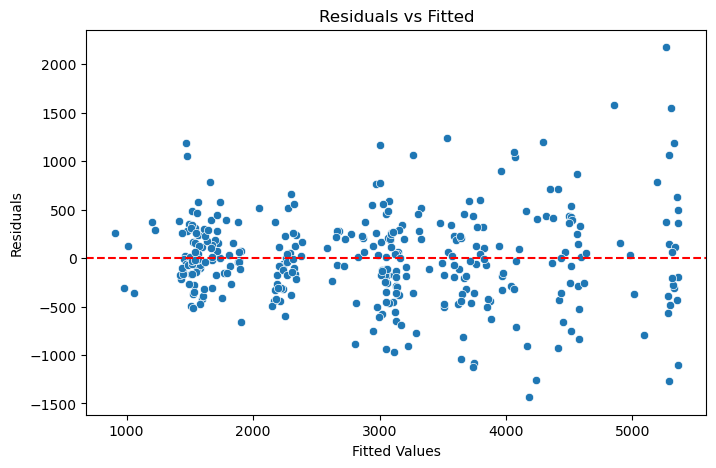

In [94]:
fitted_vals = interaction_model.fittedvalues
residuals = interaction_model.resid

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [53]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

NameError: name 'residuals' is not defined

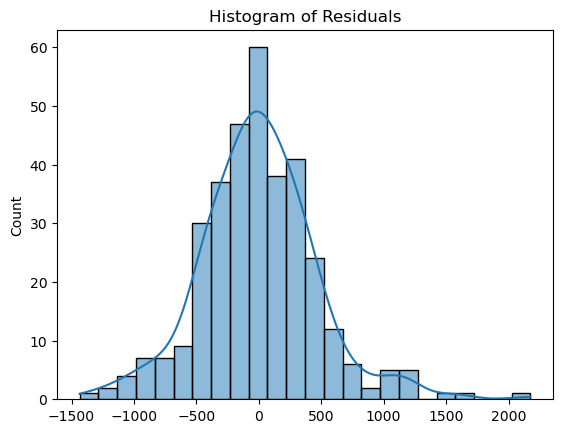

In [96]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

#### Log model - total sales



$$log(\text{total sales}_i)=\beta_0 + \beta_1 \text{ is long weekend}_i + \beta_2 \text{ is HCF}_i + \beta_3 \text{ is Friday}_i + \beta_4 \text{ is Weekend}_i  
+ \beta_5 \text{ is Holiday}_i + \beta_6 \text{ has pop up}_i + \beta_7 \text{ is Spring}_i + \beta_8 \text{ is Summer}_i + \beta_9 \text{ is Fall}_i + 
\beta_{10} \text{ hours opened}_i \\ 
+ \beta_{11} \text{ rain}_i + \beta_{12} \text{ snow}_i + \beta_{13} \text{ avg cloud cover}_i + 
\beta_{14} \text{ avg temperature}_i + \varepsilon_i$$

In [54]:
formula = (
    """
        log_total_sales_normalized ~ hours_opened 
        + C(is_long_weekend)
        + C(is_HCF) 
        + C(type_of_day) 
        + C(has_pop_up) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + C(season)
        + C(type_of_day): rain 

    """
    )


log_interaction_model = smf.ols(formula, data=train_df).fit()
print(log_interaction_model.summary())

                                OLS Regression Results                                
Dep. Variable:     log_total_sales_normalized   R-squared:                       0.863
Model:                                    OLS   Adj. R-squared:                  0.855
Method:                         Least Squares   F-statistic:                     118.9
Date:                        Wed, 21 May 2025   Prob (F-statistic):          1.74e-127
Time:                                22:42:59   Log-Likelihood:                 132.10
No. Observations:                         340   AIC:                            -228.2
Df Residuals:                             322   BIC:                            -159.3
Df Model:                                  17                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [55]:
np.exp(log_interaction_model.params)

Intercept                         591.453937
C(is_long_weekend)[T.True]          1.064202
C(is_HCF)[T.True]                   1.198928
C(type_of_day)[T.Friday]            1.524456
C(type_of_day)[T.Weekend]           1.851177
C(type_of_day)[T.Holiday]           1.740999
C(has_pop_up)[T.True]               1.039467
C(season)[T.Spring]                 1.249283
C(season)[T.Summer]                 1.443975
C(season)[T.Fall]                   0.918855
hours_opened                        1.091471
rain                                0.993190
C(type_of_day)[T.Friday]:rain       0.997094
C(type_of_day)[T.Weekend]:rain      1.001709
C(type_of_day)[T.Holiday]:rain      1.004001
snow                                0.959078
avg_cloud_cover_8                   1.003269
avg_temperature                     1.013503
dtype: float64

#### Model intepretation

**Base case:** weekday, not a long weekend, not during HCF, no pop-up, winter

**is_long_weekend** 
- No significant impact on sales

**is_HCF** 
- Holding other variables constant, on average, sales during HCF is roughly 20% higher than non-HCF days. 

**Season**
- Holding other variables constant, on average, sales in the Summer is roughly 45% higher than in the Winter.  
- Holding other variables constant, on average, sales in the Spring is roughly 25% higher than in the Winter.  
- Holding other variables constant, on average, sales in the Fall is roughly 8% lower than in the Winter.  

**type_of_day**
- Holding other variables constant, on average, sales on Friday is 52% higher than a weekday.  
- Holding other variables constant, on average, sales on the Weekend is roughly 85% higher than a weekday.  
- Holding other variables constant, on average, sales on a holiday is 77% higher than a weekday.  

**has_pop_up** 
- No significant impact on sales

**hours_opened**
- Holding other variables constant, for every additional hour opened, sales is expected to increase by 9%

**rain**
- Holding other variables constant, for every additional mm of rain recorded, sales is expected to decrease by 1%

**rain and type_of_day interaction**
- No significant interaction effect

**snow**
- Holding other variables constant, for every additional mm of snow recorded, sales is expected to decrease by roughly 4%

**avg_cloud_cover_8**
- No significant impact on sales

**avg_temperature** 
- Holding other variables constant, for every additional degree celsius recorded, sales is expected to increase by roughly 1%


#### Example

In [56]:
new_data_1 = pd.DataFrame({
    'hours_opened': [11],
    'is_long_weekend': [False],
    'is_HCF': [False],
    'type_of_day': ['Weekend'],
    'has_pop_up': [False],
    'rain': [0.0],
    'snow': [0.0],
    'avg_cloud_cover_8': [4.5],
    'avg_temperature': [19.0],
    'season': ['Summer']
})

predicted_log_sales_1 = log_interaction_model.predict(new_data_1)
np.exp(predicted_log_sales_1)

0    5421.496302
dtype: float64

In [57]:
new_data_2 = pd.DataFrame({
    'hours_opened': [11],
    'is_long_weekend': [False],
    'is_HCF': [False],
    'type_of_day': ['Weekday'],
    'has_pop_up': [False],
    'rain': [0.0],
    'snow': [0.0],
    'avg_cloud_cover_8': [4.5],
    'avg_temperature': [19.0],
    'season': ['Summer']
})

predicted_log_sales_2 = log_interaction_model.predict(new_data_2)
np.exp(predicted_log_sales_2)

0    2928.67488
dtype: float64

In [58]:
(np.exp(predicted_log_sales_1) - np.exp(predicted_log_sales_2)) / np.exp(predicted_log_sales_2)

0    0.851177
dtype: float64

#### Regression model - item_A sales

In [59]:
formula = (
    """
        log_item_A_sales ~ hours_opened 
        + C(is_long_weekend)
        + C(is_HCF) 
        + C(type_of_day) 
        + C(has_pop_up) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + C(season)
        + C(type_of_day): rain 

    """
    )


log_interaction_model_item_A = smf.ols(formula, data=train_df).fit()
print(log_interaction_model_item_A.summary())

                            OLS Regression Results                            
Dep. Variable:       log_item_A_sales   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     63.86
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.20e-92
Time:                        22:43:27   Log-Likelihood:                 80.377
No. Observations:                 340   AIC:                            -124.8
Df Residuals:                     322   BIC:                            -55.83
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

#### Regression model - item_B

In [60]:
formula = (
    """
        log_item_B_sales ~ hours_opened 
        + C(is_long_weekend)
        + C(is_HCF) 
        + C(type_of_day) 
        + C(has_pop_up) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + C(season)
        + C(type_of_day): rain 

    """
    )


log_interaction_model_softserve = smf.ols(formula, data=train_df).fit()
print(log_interaction_model_softserve.summary())

                            OLS Regression Results                            
Dep. Variable:       log_item_B_sales   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     59.24
Date:                Wed, 21 May 2025   Prob (F-statistic):           2.93e-88
Time:                        22:43:34   Log-Likelihood:                -109.72
No. Observations:                 340   AIC:                             255.4
Df Residuals:                     322   BIC:                             324.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [146]:
formula = (
    """
        log_item_C_sales ~ hours_opened 
        + C(is_long_weekend)
        + C(is_HCF) 
        + C(type_of_day) 
        + C(has_pop_up) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + C(season)
        + C(type_of_day): rain 

    """
    )


log_interaction_model_item_C = smf.ols(formula, data=train_df).fit()
print(log_interaction_model_item_C.summary())

                            OLS Regression Results                            
Dep. Variable:        log_drink_sales   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     31.05
Date:                Mon, 19 May 2025   Prob (F-statistic):           1.24e-57
Time:                        13:56:55   Log-Likelihood:                -83.420
No. Observations:                 340   AIC:                             202.8
Df Residuals:                     322   BIC:                             271.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

#### Model diagnostics

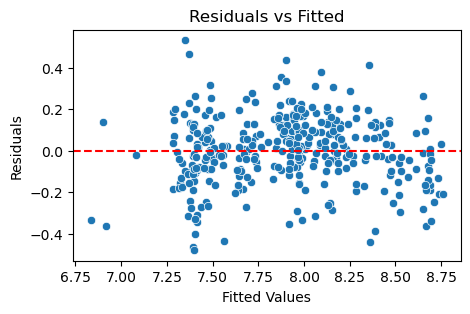

In [61]:
fitted_vals = log_interaction_model.fittedvalues
residuals = log_interaction_model.resid

plt.figure(figsize=(5, 3))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

<Figure size 400x300 with 0 Axes>

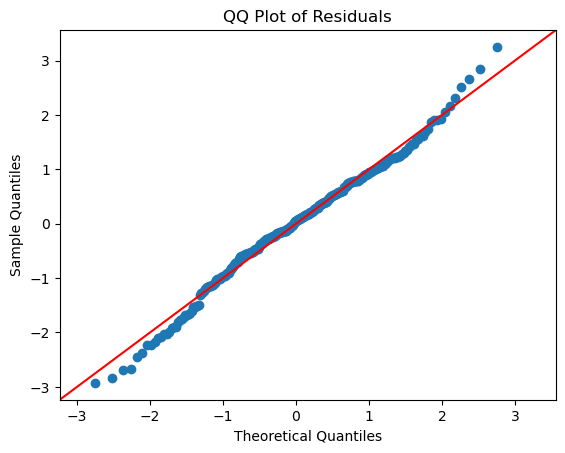

In [62]:
plt.figure(figsize=(4, 3))
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

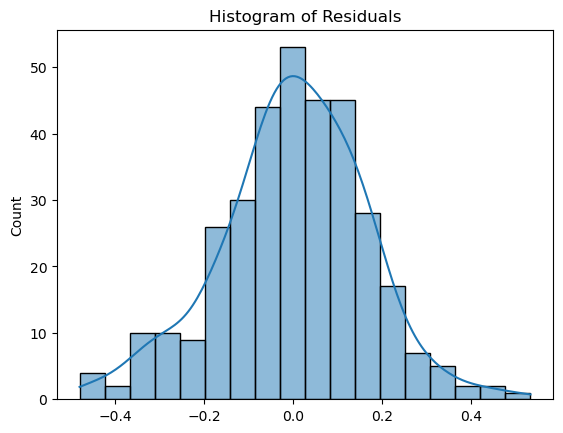

In [63]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

## Regression - prediction 

In [23]:
prediction_train_df = train_df.iloc[:-30,]
prediction_test_df = train_df.iloc[-30:,]

In [26]:
formula = (
    """
        total_sales_normalized ~ 
        + C(is_long_weekend)
        + C(is_HCF) 
        + C(has_pop_up)
        + C(day_of_week) 
        + rain 
        + snow 
        + avg_cloud_cover_8 
        + avg_temperature 
        + hours_opened
        + C(season)
        + C(is_holiday)
    """
    )

log_interaction_model = smf.ols(formula, data=prediction_train_df).fit()
print(log_interaction_model.summary())

                              OLS Regression Results                              
Dep. Variable:     total_sales_normalized   R-squared:                       0.869
Model:                                OLS   Adj. R-squared:                  0.861
Method:                     Least Squares   F-statistic:                     107.9
Date:                    Mon, 26 May 2025   Prob (F-statistic):          1.22e-117
Time:                            21:05:54   Log-Likelihood:                -2354.3
No. Observations:                     312   AIC:                             4747.
Df Residuals:                         293   BIC:                             4818.
Df Model:                              18                                         
Covariance Type:                nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [256]:
y_pred = log_interaction_model.predict(prediction_test_df[['is_long_weekend', 'is_HCF', 'day_of_week', 'has_pop_up', 'season', 'hours_opened', 'rain', 'snow', 'avg_cloud_cover_8', 'avg_temperature']])
y_pred = np.exp(y_pred)
y_pred

328    3859.144795
329    4867.944477
330    4562.547751
331    2313.753585
332    2179.991250
333    2389.421620
334    2394.950146
335    4009.857300
336    4770.427052
337    4482.496898
338    2465.396941
339    2238.159961
340    2501.005123
341    2354.864761
dtype: float64

In [252]:
y_test = np.exp(prediction_test_df['log_total_sales_normalized'])

In [253]:
mean_absolute_error(y_test, y_pred)

272.0479346670229

In [ ]:
X_train, y_train = train_test_split()

## Time Series

In [188]:
total_sales_df = combined_df[['date', 'total_sales_normalized']]
total_sales_df.set_index('date', inplace=True)

item_A_sales_df = combined_df[['date', 'item_A_sales']]
item_A_sales_df.set_index('date', inplace=True)

item_B_sales_df = combined_df[['date', 'item_B_sales']]
item_B_sales_df.set_index('date', inplace=True)

item_C_sales_df = combined_df[['date', 'item_C_sales']]
item_C_sales_df.set_index('date', inplace=True)

combined_sales_df = pd.concat([total_sales_df, item_A_sales_df, item_B_sales_df, item_C_sales_df], axis=1)

In [189]:
fig = px.line(combined_sales_df, title='Daily sales')


fig.add_vline(
    x=pd.to_datetime('2025-03-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Spring begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-12-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Winter begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-09-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Fall begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vrect(x0="2025-01-18", x1="2025-2-14", 
              annotation_text="HCF", annotation_position="top left",
              fillcolor="green", opacity=0.1, line_width=0)


fig.show()

In [190]:
combined_sales_resample = combined_sales_df.resample('W').mean()

fig = px.line(combined_sales_resample, title='Weekly sales')

fig.add_vline(
    x=pd.to_datetime('2025-03-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Spring begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-12-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Winter begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-09-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Fall begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vrect(x0="2025-01-18", x1="2025-2-14", 
              annotation_text="HCF", annotation_position="top left",
              fillcolor="green", opacity=0.1, line_width=0)


fig.show()

In [226]:
decompose_model = seasonal_decompose(combined_df[["total_sales_normalized"]], model="additive", period=7)
trend = decompose_model.trend 
seasonal = decompose_model.seasonal
residuals = decompose_model.resid


decompose_df = pd.DataFrame(
    {"total_sales_normalized": combined_df['total_sales_normalized'],
     'trend': trend,
     'seasonal': seasonal,
     'residuals': residuals
    }
)

decompose_df.set_index(combined_df['date'], inplace=True)
decompose_df['day_of_week'] = decompose_df.index.day_name()
decompose_df

,total_sales_normalized,trend,seasonal,residuals,day_of_week
date,,,,,
2024-06-01,6433.36,NaN,1426.468011,NaN,Saturday
2024-06-02,4755.46,NaN,1109.762267,NaN,Sunday
2024-06-03,3487.14,NaN,-648.246164,NaN,Monday
2024-06-04,3739.60,4498.997143,-947.793804,188.396661,Tuesday
2024-06-05,4172.75,4643.494286,-721.092376,250.348090,Wednesday
...,...,...,...,...,...
2025-05-04,4863.03,3440.885714,1109.762267,312.382018,Sunday
2025-05-05,2578.74,3382.581429,-648.246164,-155.595265,Monday
2025-05-06,2401.45,NaN,-947.793804,NaN,Tuesday


<Axes: title={'center': 'Seasonal differenced'}, xlabel='date'>

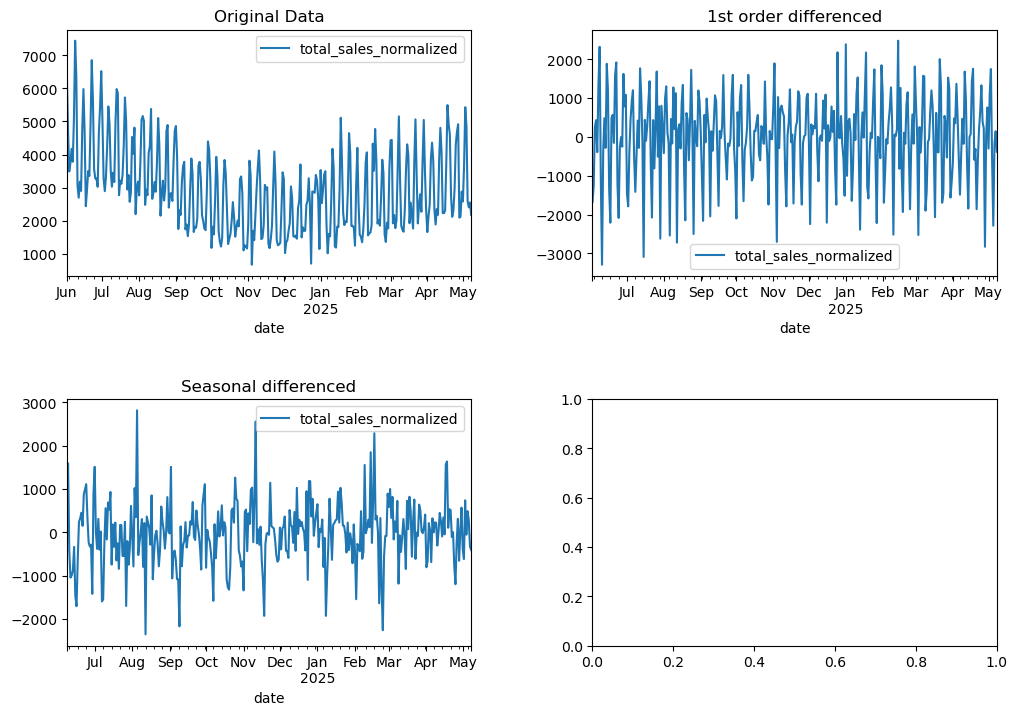

In [191]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

total_sales_df.plot(ax=axes[0,0], title='Original Data')

total_sales_diff = total_sales_df.diff().dropna() # 1st order diff
total_sales_diff.plot(ax=axes[0,1], title='1st order differenced')

total_sales_seasonal_diff = total_sales_df.diff(7).dropna()
total_sales_seasonal_diff.plot(ax=axes[1,0], title='Seasonal differenced')


In [192]:
result_adf = adfuller(total_sales_diff)

print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])

ADF Statistic: -8.005518
p-value: 0.000000


### SARIMA

In [201]:
y = combined_df[['date','total_sales_normalized']].set_index('date')
y_train = y.iloc[0: - 14].assign(Label = 'train')
y_valid = y.iloc[len(y) - 14 :].assign(Label = "test")

In [205]:
total_sales_df.iloc[0:-14]

,total_sales_normalized
date,
2024-06-01,6433.36
2024-06-02,4755.46
2024-06-03,3487.14
2024-06-04,3739.60
2024-06-05,4172.75
...,...
2025-04-20,4605.99
2025-04-21,2746.16
2025-04-22,2115.67


In [216]:
autoarima = pm.auto_arima(total_sales_df.iloc[0:-14], seasonal=True, m=7)
autoarima.get_params()

best_order = autoarima.get_params()['order']
best_seasonal_order = autoarima.get_params()['seasonal_order']

In [217]:
sarima_model = ARIMA(y_train['total_sales_normalized'], order=best_order, seasonal_order=best_seasonal_order).fit()
sarima_forecast = pd.DataFrame({"total_sales_normalized":sarima_model.forecast(len(y_valid)),
                               "Label":"SARIMA"})
sarima_forecast.index = y_valid.index

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [218]:
px.line(pd.concat((y_train, y_valid, sarima_forecast)), y="total_sales_normalized", width=640, color="Label")

In [221]:
comparison = pd.DataFrame({
    'valid': y_valid['total_sales_normalized'],
    'sarima(5,1,3)': sarima_forecast['total_sales_normalized']
})
comparison['Error'] = comparison['sarima(5,1,3)'] - comparison['valid'] 
comparison['day_of_week'] = comparison.index.day_name()
comparison


,valid,"sarima(5,1,3)",Error,day_of_week
date,,,,
2025-04-25,4298.72,4300.683425,1.963425,Friday
2025-04-26,4691.59,4716.800327,25.210327,Saturday
2025-04-27,4916.85,4065.424088,-851.425912,Sunday
2025-04-28,2089.56,2442.606864,353.046864,Monday
2025-04-29,2119.33,2174.756482,55.426482,Tuesday
2025-04-30,2878.26,2361.910297,-516.349703,Wednesday
2025-05-01,2579.39,2792.911099,213.521099,Thursday
2025-05-02,3681.24,4228.803360,547.563360,Friday
2025-05-03,5432.51,4673.879007,-758.630993,Saturday


In [249]:
abs(comparison['Error']).mean()


377.2499084968612

In [224]:
decompose_df

,total_sales_normalized,trend,seasonal,residuals
date,,,,
2024-06-01,6433.36,NaN,1426.468011,NaN
2024-06-02,4755.46,NaN,1109.762267,NaN
2024-06-03,3487.14,NaN,-648.246164,NaN
2024-06-04,3739.60,4498.997143,-947.793804,188.396661
2024-06-05,4172.75,4643.494286,-721.092376,250.348090
...,...,...,...,...
2025-05-04,4863.03,3440.885714,1109.762267,312.382018
2025-05-05,2578.74,3382.581429,-648.246164,-155.595265
2025-05-06,2401.45,NaN,-947.793804,NaN


#### Notes 

- divide into 4 season blocks, do train/test within each block - regression
- SARIMAX - whole series 
- 1000 random train / test split -> look at RMSE 

- Question:
  - how to interpret when main variable is not significant but interaction affect is
  - how big should test set be if i only want to forecast 7 days ahead